## gpu-rsi experimental feature
- This notebook uses the bvhIntersectionKernel API that returns the number of ray-surface intersections
- The odd/even parity test is used to indicate points inside/outside the surface

In [1]:
__copyright__ = "Copyright (c) 2022, Raymond Leung"
__license__   = "BSD-3-clause"

In [2]:
import numpy as np
import os, shutil, sys
import re
import requests
import zipfile
from gpu_ray_surface_intersect import PyGpuRSI

In [3]:
GPU_CODE_DIR = os.getcwd().replace('scripts', '')
WORK_DIR = os.getcwd().replace('scripts', 'scratch')
DATA_DIR = os.path.join(WORK_DIR, 'input')
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
os.chdir(WORK_DIR)

In [4]:
# For testing, use a hole-filled version of the "Stanford Bunny" surface provided by
# Morgan McGuire, Computer Graphics Archive, July 2017
# (https://casual-effects.com/g3d/data10/research/model/bunny/bunny.zip)
# (c) 1996 Stanford University (www.graphics.stanford.edu/dat/3Dscanrep/)

url='http://casual-effects.com/g3d/data10/research/model/bunny/bunny.zip'
hdr={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}

def download_file(url):
    local_filename = url.split('/')[-1]
    with requests.get(url, headers=hdr, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    print('downloaded ' + local_filename)
    return local_filename

filename = download_file(url)
datafile = os.path.join(os.getcwd(), filename) 
with zipfile.ZipFile(datafile, 'r') as zobj:
    zobj.extractall()
# If any issue is encountered, download the file directly from the url
# unzip it and put bunny.obj in the scratch/ directory before proceeding

downloaded bunny.zip


In [5]:
# Parse the .obj file
# - read triangle mesh surface from .obj file, return vertices and triangles
#   as (nV,3) and (nT,3) arrays. For the Stanford Bunny, nV=72027 and nT=144046
# - min: [-0.9559, 0.021, -0.543]
# - max: [0.6579, 1.6418, 0.6895]
# - range: [1.6138, 1.6208, 1.2325]

rv = re.compile(r'^v\s+(?P<vx>-?[\d\.]+)\s+(?P<vy>-?[\d\.]+)\s+(?P<vz>-?[\d\.]+)', re.MULTILINE)
rf = re.compile(r'^f\s+(?P<fa>[\d]+)/[\d]+/[\d]+\s+(?P<fb>[\d]+)/[\d]+/[\d]+\s+(?P<fc>[\d]+)/[\d]+/[\d]+\s+', re.MULTILINE)
str2float = lambda m: [float(m.group('vx')),float(m.group('vy')),float(m.group('vz'))]
str2int = lambda m: [int(m.group('fa')),int(m.group('fb')),int(m.group('fc'))]

with open("bunny.obj") as f:
    raw_data = f.read()
    # Generate mesh vertices and triangles
    vertices = np.array([str2float(match) for match in rv.finditer(raw_data)])
    triangles = np.array([str2int(match) for match in rf.finditer(raw_data)]) - 1 #index starts at 0

    import pyvista as pv
    mesh = pv.PolyData('/home/wangl/repos/deepdrr/tests/resources/10cmcube.stl')
    vertices = np.array(mesh.points, dtype=np.float32)*1000
    triangles = mesh.faces.reshape((-1, 4))[..., 1:][..., [0, 2, 1]].astype(np.int32)  # flip winding order



xyz_max = np.max(vertices,axis=0)
xyz_min = np.min(vertices,axis=0)
xyz_range = xyz_max - xyz_min

# Generate line segments
# - pick starting points randomly
n = 1000000
np.random.seed(6204)
rayFrom = xyz_min - 0.15 * xyz_range + np.random.rand(n,3) * (1.3 * xyz_range)
rayTo = rayFrom + 2 * xyz_range[-1] * np.r_[0,0,1.]
rayUp = rayTo
rayDown = 2 * rayFrom - rayTo

# Write data to binary files
fw = lambda f: os.path.join(os.getcwd(), f)
verts = np.array(vertices.flatten(),'float32')
tris = np.array(triangles.flatten(),'int32')
pFrom = np.array(rayFrom.flatten(),'float32')
pUp = np.array(rayUp.flatten(),'float32')
pDown = np.array(rayDown.flatten(),'float32')
with open(fw('vertices_f32'), 'wb') as f:
    verts.tofile(f)
with open(fw('triangles_i32'), 'wb') as f:
    tris.tofile(f)
with open(fw('rayFrom_f32'), 'wb') as f:
    pFrom.tofile(f)
with open(fw('rayUp_f32'), 'wb') as f:
    pUp.tofile(f)
with open(fw('rayDown_f32'), 'wb') as f:
    pDown.tofile(f)

#### (Part C) Run CUDA program in "intercept_count" mode to return number of ray-surface intersections

In [6]:
# Configuration
parms = {'mode':'intercept_count', 'keep_cuda_binary': False}

In [7]:
# GPU ray-segment surface intersection tests are invoked below
rsi = PyGpuRSI(GPU_CODE_DIR, WORK_DIR, cfg=parms)

#(a) cast the ray upward
surface_intersections = {}
surface_intersections['up'] = rsi.test(vertices, triangles, rayFrom, rayUp)
#(b) cast the ray downward
surface_intersections['down'] = rsi.test(vertices, triangles, rayFrom, rayDown)

for dir in ['up', 'down']:
    hits, freq = np.unique(surface_intersections[dir], return_counts=1)
    desc = ', '.join(['{}:{}'.format(k,v) for k,v in zip(hits, freq)])
    print('{}: {}'.format(dir, desc))

compiling CUDA code...
nvcc compilation succeeded!
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/vertices_f32 contains 96 bytes, 24 <f>, 8 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/triangles_i32 contains 144 bytes, 36 <i>, 12 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/rayFrom_f32 contains 12000000 bytes, 3000000 <f>, 1000000 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/rayTo_f32 contains 12000000 bytes, 3000000 <f>, 1000000 elements
1024 threads/block, grids: {triangles: 1, rays: 16}
[-100, 100] delta: 9.53675e-05
[-100, 100] delta: 9.53675e-05
[-100, 100] delta: 9.53675e-05
checking sortMortonCode
0: (0) 878416384462359600
1: (10) 1464027307437266001
2: (3) 1756832768924719201
3: (4) 2488846422643352202
4: (1) 3367262807105711802
5: (2) 4245679191568071403
6: (9) 4831290114542977804
7: (11) 5709706499005337404
8: (8) 6295317421980243805
9: (6) 7027331075698876

In [10]:
# Interpret points as inside surface for odd parity
# within_surface = surface_intersections['up'] == 10
within_surface = np.logical_and(np.mod(surface_intersections['up'], 2) == 1, np.mod(surface_intersections['down'], 2) == 1)

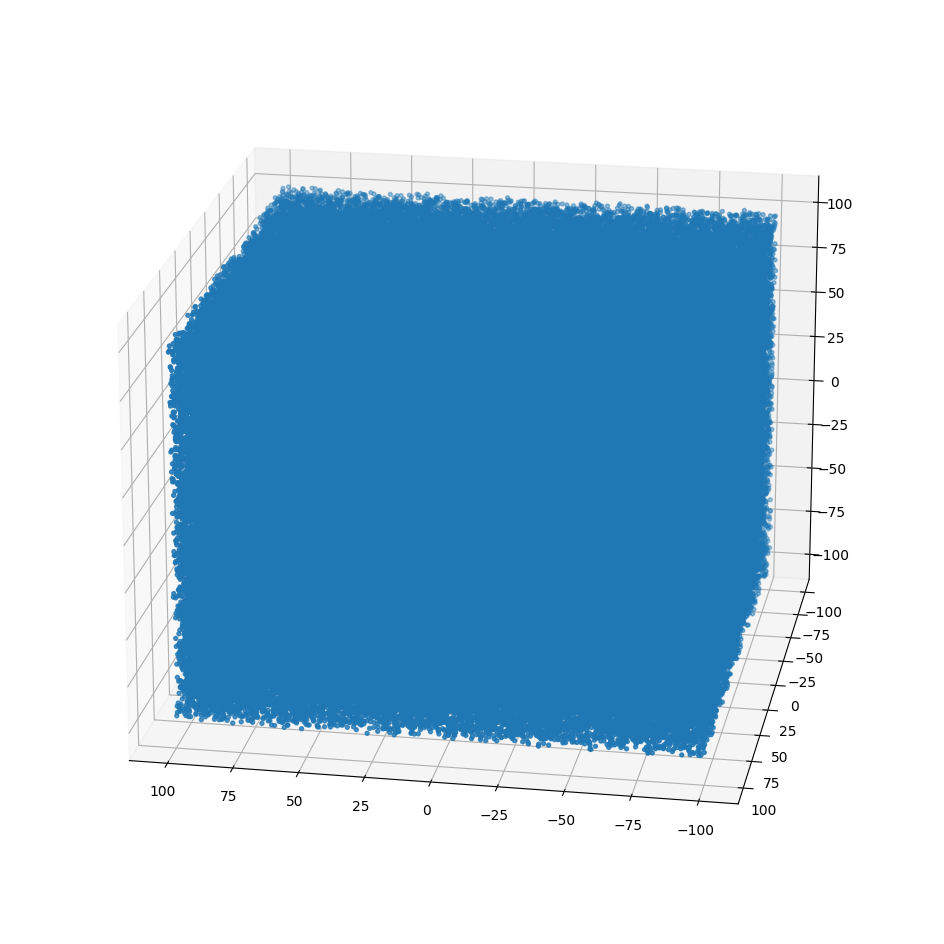

In [11]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rayFrom = np.fromfile('input/rayFrom_f32', dtype=np.float32).reshape((1000000,3))
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(projection='3d')
idx = np.where(within_surface)
ax.scatter(rayFrom[idx,0], -rayFrom[idx,2], rayFrom[idx,1], s=8)
ax.view_init(elev=20., azim=100)
plt.show()

In [ ]:
rsi.cleanup()
os.remove(os.path.join(WORK_DIR, 'bunny.obj'))

cleaning up...
